I followed the tutoral by Sovid Ranja Rath to train a Vanilla GAN to generate MNIST Digit images

https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/

## Training the Discriminator

- First, we get the real data and the real labels (real labels are all 1s). The length of the real label should be equal to the batch size.

- Then we do a forward pass by feeding the real data to the discriminator neural network. This gives us the real outputs from the real data.

- Calculate the discriminator loss for the real outputs and labels and backpropagate it.

- Get the fake data using the noise vector and doing a forward pass through the generator. Get fake labels as well.

- Using the fake data, do a forward pass through the discriminator. Calculate the loss using the fake data outputs and the fake labels. Backpropagate the fake data loss. Then calculate the total discriminator loss by adding real data loss and fake data loss.

- Update the discriminator optimizer parameters.

## Training the Generator
- For the generator training, first, get the fake data by doing a forward pass through the generator. Get the real labels (all 1s).

- Then do a forward pass through the discriminator using the fake data and the labels.

- Calculate the loss and backpropagate them.

- But this time, update the generator optimizer parameters.


Import modules and libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
matplotlib.style.use('ggplot')

Define the learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 200
sample_size = 64 # fixed sample size
nz = 128 # latent vector size or noise vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Prepare dataset

line 1 will convert the image to tensors and normalizes them.

line 6 will convert the images to the PIL image format.

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

In [4]:
train_data = datasets.MNIST(
    root='./input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

## Generator Neural Network

4 linear layers with LeakyReLu activations in-between

forward( ) returns the outputs after reshaping them into batch_size * 1 * 28 * 28

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

## Discriminator Neural Network

forward( ) makes a forward pass of the data through the discriminator network. It returns the binary classification of whether an image is fake or real (0 or 1)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)


## Initialize the Neural Networks and Define the Optimizers


In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [8]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [9]:
# loss function, Binary Cross Entropy Loss Function
criterion = nn.BCELoss()

In [10]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

## Utility Functions

Real and fake labels for the real image and the fake image data from the generator

In [11]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [12]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [13]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

## Function to Train the Discriminator
- At line 3, we get the batch size of the data. Then we use the batch size to create the fake and real labels at lines 4 and 5.
- Before doing any training, we first set the gradients to zero at line 7.
- At line 9, we get the output_real by doing a forward pass of the real data (data_real) through the discriminator. Line 10 calculates the loss for the real outputs and the real labels.
- Similarly, at line 12, we get fake outputs using fake data. And line 13, calculates the loss for the fake outputs and the fake labels.
- Lines 16 to 18 backpropagate the gradients for the fake and the real loss and update the parameters as well.
- Finally, at line 20, we return the total loss for the discriminator network.

In [14]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)  #get the batck size
    
    #create labels
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    
    optimizer.zero_grad()
    
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

## Function to Train the Generator
- First, we get the batch size at line 3 and then create the real labels at line 4. Remember that the fake data is actually real for the generator. Therefore, we are using real labels (ones) for training the generator network.
- At line 6, we set the gradients to zero.
- The next step is a bit important. At line 8, we pass the fake data through the discriminator and get the outputs. Then at line 9, we calculate the loss using the outputs and the real labels.
- Remember that the generator only generates fake data. And it improves after each iteration by taking in the feedback from the discriminator.
- At line 11, we backpropagate the gradients.
- Now, at line 12, we update the generator parameters and not the discriminator parameters. Because in this step, we want the generator to learn, not the discriminator. The optimizer parameter in the function definition is the optim_g that we will pass as the argument while calling the function.


In [15]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

## Training the GAN

In [16]:
# create the noise vector
noise = create_noise(sample_size, nz)

In [17]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

## The Training Loop
- At lines 2 and 3, we define loss_g and loss_d to keep track of the batch-wise loss values for the discriminator and the generator.
- Starting from line 4, we iterate through the batches. We only need the image data. Therefore, we get the images only at line 5 and load them to the computation device at line 6. Line 7 calculates the batch size.
- Starting from line 9 till 13, we run the discriminator for k number of steps. And remember that for our purpose we have defined k = 1. This is the least expensive option as this will train one step of the discriminator and one step of the generator. You can play around with the value of k. But remember that the computation time will also increase with an increase in the value of k.
- Also, note that we are passing the discriminator optimizer while calling train_discriminator() at line 13.
- At line 14, we again create a new noise vector. This we pass as an argument along with the generator optimizer while calling train_generator().
- At line 19, we create the final fake images for the current epoch and load them onto the CPU so that we can save them to the disk. Line 21 makes a grid of those images.
- Line 23 saves the generated images to disk. And line 24 appends those images to the images list.
- Finally, from line 25 to 31, we calculate the epoch-wise loss of the generator and the discriminator and print those loss values.


In [18]:
for epoch in range(epochs):

    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    # make the images as grid
    generated_img = make_grid(generated_img)
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"./output/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g.detach().numpy() / bi # total generator loss for the epoch
    epoch_loss_d = loss_d.detach().numpy() / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch + 1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:07, 14.94it/s]                                                        


Epoch 1 of 200
Generator loss: 1.41767636, Discriminator loss: 0.86094907


118it [00:07, 14.97it/s]                                                        


Epoch 2 of 200
Generator loss: 2.05820328, Discriminator loss: 1.37316164


118it [00:07, 15.02it/s]                                                        


Epoch 3 of 200
Generator loss: 3.20419364, Discriminator loss: 0.95531457


118it [00:07, 14.76it/s]                                                        


Epoch 4 of 200
Generator loss: 1.78229529, Discriminator loss: 1.02636125


118it [00:07, 14.84it/s]                                                        


Epoch 5 of 200
Generator loss: 1.58340285, Discriminator loss: 1.03370262


118it [00:07, 14.78it/s]                                                        


Epoch 6 of 200
Generator loss: 1.41282719, Discriminator loss: 1.24572780


118it [00:07, 14.82it/s]                                                        


Epoch 7 of 200
Generator loss: 1.91709561, Discriminator loss: 1.13018512


118it [00:08, 14.64it/s]                                                        


Epoch 8 of 200
Generator loss: 2.25837668, Discriminator loss: 1.21483110


118it [00:07, 14.86it/s]                                                        


Epoch 9 of 200
Generator loss: 1.62427032, Discriminator loss: 0.99553113


118it [00:07, 14.82it/s]                                                        


Epoch 10 of 200
Generator loss: 2.05109829, Discriminator loss: 1.19809195


118it [00:07, 14.86it/s]                                                        


Epoch 11 of 200
Generator loss: 1.93337413, Discriminator loss: 1.13496999


118it [00:07, 14.80it/s]                                                        


Epoch 12 of 200
Generator loss: 1.04002178, Discriminator loss: 1.27977785


118it [00:07, 14.92it/s]                                                        


Epoch 13 of 200
Generator loss: 0.97310312, Discriminator loss: 1.19518130


118it [00:07, 14.95it/s]                                                        


Epoch 14 of 200
Generator loss: 1.13222210, Discriminator loss: 1.06518190


118it [00:07, 14.92it/s]                                                        


Epoch 15 of 200
Generator loss: 2.59555836, Discriminator loss: 0.95454192


118it [00:07, 14.86it/s]                                                        


Epoch 16 of 200
Generator loss: 3.19309072, Discriminator loss: 0.78862586


118it [00:07, 14.93it/s]                                                        


Epoch 17 of 200
Generator loss: 2.41078669, Discriminator loss: 0.77620241


118it [00:07, 14.87it/s]                                                        


Epoch 18 of 200
Generator loss: 2.69360482, Discriminator loss: 0.58266266


118it [00:07, 14.83it/s]                                                        


Epoch 19 of 200
Generator loss: 3.08110346, Discriminator loss: 0.50062059


118it [00:07, 14.88it/s]                                                        


Epoch 20 of 200
Generator loss: 3.23472947, Discriminator loss: 0.48990905


118it [00:07, 14.94it/s]                                                        


Epoch 21 of 200
Generator loss: 2.85471494, Discriminator loss: 0.61952372


118it [00:07, 14.88it/s]                                                        


Epoch 22 of 200
Generator loss: 2.93675714, Discriminator loss: 0.59464479


118it [00:07, 14.83it/s]                                                        


Epoch 23 of 200
Generator loss: 3.02857436, Discriminator loss: 0.49480272


118it [00:07, 14.93it/s]                                                        


Epoch 24 of 200
Generator loss: 3.03004703, Discriminator loss: 0.38257221


118it [00:07, 14.84it/s]                                                        


Epoch 25 of 200
Generator loss: 3.31610812, Discriminator loss: 0.44751100


118it [00:08, 14.69it/s]                                                        


Epoch 26 of 200
Generator loss: 2.61790219, Discriminator loss: 0.58068202


118it [00:08, 14.67it/s]                                                        


Epoch 27 of 200
Generator loss: 3.22605883, Discriminator loss: 0.57745994


118it [00:08, 14.71it/s]                                                        


Epoch 28 of 200
Generator loss: 2.64861643, Discriminator loss: 0.56589645


118it [00:07, 14.94it/s]                                                        


Epoch 29 of 200
Generator loss: 2.89621546, Discriminator loss: 0.48616409


118it [00:08, 14.40it/s]                                                        


Epoch 30 of 200
Generator loss: 2.85559578, Discriminator loss: 0.48916020


118it [00:08, 14.65it/s]                                                        


Epoch 31 of 200
Generator loss: 2.65521892, Discriminator loss: 0.60049843


118it [00:08, 14.52it/s]                                                        


Epoch 32 of 200
Generator loss: 2.43679940, Discriminator loss: 0.60595860


118it [00:08, 14.28it/s]                                                        


Epoch 33 of 200
Generator loss: 2.91699975, Discriminator loss: 0.51502877


118it [00:08, 14.68it/s]                                                        


Epoch 34 of 200
Generator loss: 2.72999221, Discriminator loss: 0.48179760


118it [00:07, 14.87it/s]                                                        


Epoch 35 of 200
Generator loss: 2.93589796, Discriminator loss: 0.54924605


118it [00:07, 14.83it/s]                                                        


Epoch 36 of 200
Generator loss: 3.05230061, Discriminator loss: 0.51578173


118it [00:07, 14.93it/s]                                                        


Epoch 37 of 200
Generator loss: 3.02018568, Discriminator loss: 0.49404193


118it [00:08, 14.21it/s]                                                        


Epoch 38 of 200
Generator loss: 3.34869698, Discriminator loss: 0.44034909


118it [00:08, 14.41it/s]                                                        


Epoch 39 of 200
Generator loss: 3.05358626, Discriminator loss: 0.49395765


118it [00:08, 14.63it/s]                                                        


Epoch 40 of 200
Generator loss: 3.02245833, Discriminator loss: 0.50399366


118it [00:08, 14.68it/s]                                                        


Epoch 41 of 200
Generator loss: 2.77508754, Discriminator loss: 0.52723074


118it [00:07, 14.88it/s]                                                        


Epoch 42 of 200
Generator loss: 2.94392330, Discriminator loss: 0.49401722


118it [00:08, 14.66it/s]                                                        


Epoch 43 of 200
Generator loss: 3.17135151, Discriminator loss: 0.46178042


118it [00:07, 14.85it/s]                                                        


Epoch 44 of 200
Generator loss: 3.33711021, Discriminator loss: 0.40246494


118it [00:08, 14.61it/s]                                                        


Epoch 45 of 200
Generator loss: 2.95938476, Discriminator loss: 0.50426910


118it [00:08, 14.56it/s]                                                        


Epoch 46 of 200
Generator loss: 3.00828018, Discriminator loss: 0.52223228


118it [00:07, 14.89it/s]                                                        


Epoch 47 of 200
Generator loss: 2.88264165, Discriminator loss: 0.48836038


118it [00:07, 14.94it/s]                                                        


Epoch 48 of 200
Generator loss: 2.86746372, Discriminator loss: 0.54446760


118it [00:08, 14.67it/s]                                                        


Epoch 49 of 200
Generator loss: 3.05957788, Discriminator loss: 0.48133518


118it [00:08, 14.72it/s]                                                        


Epoch 50 of 200
Generator loss: 3.06898251, Discriminator loss: 0.50975760


118it [00:07, 14.77it/s]                                                        


Epoch 51 of 200
Generator loss: 2.90200388, Discriminator loss: 0.52185486


118it [00:08, 14.72it/s]                                                        


Epoch 52 of 200
Generator loss: 2.94996917, Discriminator loss: 0.50955148


118it [00:07, 14.95it/s]                                                        


Epoch 53 of 200
Generator loss: 2.84696713, Discriminator loss: 0.56754192


118it [00:07, 14.91it/s]                                                        


Epoch 54 of 200
Generator loss: 2.87207814, Discriminator loss: 0.55286447


118it [00:08, 14.68it/s]                                                        


Epoch 55 of 200
Generator loss: 2.72916823, Discriminator loss: 0.56741385


118it [00:08, 13.95it/s]                                                        


Epoch 56 of 200
Generator loss: 2.93621278, Discriminator loss: 0.55087789


118it [00:08, 14.53it/s]                                                        


Epoch 57 of 200
Generator loss: 2.98074706, Discriminator loss: 0.51391034


118it [00:07, 14.86it/s]                                                        


Epoch 58 of 200
Generator loss: 2.89347044, Discriminator loss: 0.51308037


118it [00:07, 14.79it/s]                                                        


Epoch 59 of 200
Generator loss: 2.87368931, Discriminator loss: 0.53407874


118it [00:07, 14.78it/s]                                                        


Epoch 60 of 200
Generator loss: 2.94100144, Discriminator loss: 0.49730011


118it [00:07, 14.94it/s]                                                        


Epoch 61 of 200
Generator loss: 2.92596931, Discriminator loss: 0.57308419


118it [00:07, 14.94it/s]                                                        


Epoch 62 of 200
Generator loss: 2.60903200, Discriminator loss: 0.56883292


118it [00:07, 14.99it/s]                                                        


Epoch 63 of 200
Generator loss: 2.72012616, Discriminator loss: 0.55915702


118it [00:08, 14.74it/s]                                                        


Epoch 64 of 200
Generator loss: 2.56758809, Discriminator loss: 0.59917965


118it [00:07, 15.21it/s]                                                        


Epoch 65 of 200
Generator loss: 2.69293839, Discriminator loss: 0.58639898


118it [00:07, 15.69it/s]                                                        


Epoch 66 of 200
Generator loss: 2.65440799, Discriminator loss: 0.60535327


118it [00:07, 15.65it/s]                                                        


Epoch 67 of 200
Generator loss: 2.36300685, Discriminator loss: 0.66913716


118it [00:07, 15.50it/s]                                                        


Epoch 68 of 200
Generator loss: 2.44950254, Discriminator loss: 0.63647741


118it [00:07, 15.52it/s]                                                        


Epoch 69 of 200
Generator loss: 2.45785966, Discriminator loss: 0.59511364


118it [00:07, 15.67it/s]                                                        


Epoch 70 of 200
Generator loss: 2.50102377, Discriminator loss: 0.57470338


118it [00:08, 14.62it/s]                                                        


Epoch 71 of 200
Generator loss: 2.56827486, Discriminator loss: 0.55786902


118it [00:07, 15.54it/s]                                                        


Epoch 72 of 200
Generator loss: 2.61735287, Discriminator loss: 0.57832076


118it [00:07, 15.68it/s]                                                        


Epoch 73 of 200
Generator loss: 2.54908974, Discriminator loss: 0.58424664


118it [00:07, 15.69it/s]                                                        


Epoch 74 of 200
Generator loss: 2.38259027, Discriminator loss: 0.64891978


118it [00:07, 15.52it/s]                                                        


Epoch 75 of 200
Generator loss: 2.50458338, Discriminator loss: 0.63521185


118it [00:07, 15.65it/s]                                                        


Epoch 76 of 200
Generator loss: 2.35209095, Discriminator loss: 0.68697918


118it [00:07, 15.69it/s]                                                        


Epoch 77 of 200
Generator loss: 2.38248124, Discriminator loss: 0.67955278


118it [00:07, 15.66it/s]                                                        


Epoch 78 of 200
Generator loss: 2.33082359, Discriminator loss: 0.67802234


118it [00:07, 15.73it/s]                                                        


Epoch 79 of 200
Generator loss: 2.35724190, Discriminator loss: 0.64968155


118it [00:07, 15.68it/s]                                                        


Epoch 80 of 200
Generator loss: 2.36712464, Discriminator loss: 0.66939049


118it [00:07, 15.73it/s]                                                        


Epoch 81 of 200
Generator loss: 2.22851615, Discriminator loss: 0.65556296


118it [00:07, 15.65it/s]                                                        


Epoch 82 of 200
Generator loss: 2.26787730, Discriminator loss: 0.67325918


118it [00:07, 15.70it/s]                                                        


Epoch 83 of 200
Generator loss: 2.36339184, Discriminator loss: 0.66866602


118it [00:07, 15.76it/s]                                                        


Epoch 84 of 200
Generator loss: 2.22082467, Discriminator loss: 0.69594339


118it [00:07, 15.72it/s]                                                        


Epoch 85 of 200
Generator loss: 2.24960275, Discriminator loss: 0.70485622


118it [00:07, 15.65it/s]                                                        


Epoch 86 of 200
Generator loss: 2.27016873, Discriminator loss: 0.69235282


118it [00:07, 15.57it/s]                                                        


Epoch 87 of 200
Generator loss: 2.19637149, Discriminator loss: 0.74310877


118it [00:07, 15.62it/s]                                                        


Epoch 88 of 200
Generator loss: 2.23842471, Discriminator loss: 0.72670583


118it [00:07, 15.44it/s]                                                        


Epoch 89 of 200
Generator loss: 2.15952386, Discriminator loss: 0.76314806


118it [00:07, 15.06it/s]                                                        


Epoch 90 of 200
Generator loss: 2.04751717, Discriminator loss: 0.74401308


118it [00:08, 14.64it/s]                                                        


Epoch 91 of 200
Generator loss: 2.19278763, Discriminator loss: 0.72336833


118it [00:07, 15.38it/s]                                                        


Epoch 92 of 200
Generator loss: 2.10113643, Discriminator loss: 0.72625654


118it [00:07, 15.41it/s]                                                        


Epoch 93 of 200
Generator loss: 2.14544300, Discriminator loss: 0.73617339


118it [00:07, 15.69it/s]                                                        


Epoch 94 of 200
Generator loss: 2.12093725, Discriminator loss: 0.73817072


118it [00:07, 15.52it/s]                                                        


Epoch 95 of 200
Generator loss: 2.08472606, Discriminator loss: 0.75097369


118it [00:07, 15.53it/s]                                                        


Epoch 96 of 200
Generator loss: 2.08714816, Discriminator loss: 0.77524404


118it [00:07, 15.47it/s]                                                        


Epoch 97 of 200
Generator loss: 1.91470011, Discriminator loss: 0.79962889


118it [00:07, 15.63it/s]                                                        


Epoch 98 of 200
Generator loss: 2.06072098, Discriminator loss: 0.75977730


118it [00:07, 15.58it/s]                                                        


Epoch 99 of 200
Generator loss: 1.97377145, Discriminator loss: 0.77855004


118it [00:07, 15.72it/s]                                                        


Epoch 100 of 200
Generator loss: 1.94102948, Discriminator loss: 0.81010352


118it [00:07, 15.67it/s]                                                        


Epoch 101 of 200
Generator loss: 1.91513531, Discriminator loss: 0.81963818


118it [00:07, 15.73it/s]                                                        


Epoch 102 of 200
Generator loss: 1.89126939, Discriminator loss: 0.82271908


118it [00:07, 15.71it/s]                                                        


Epoch 103 of 200
Generator loss: 1.85080008, Discriminator loss: 0.80755139


118it [00:07, 15.61it/s]                                                        


Epoch 104 of 200
Generator loss: 1.84722692, Discriminator loss: 0.80230152


118it [00:07, 15.69it/s]                                                        


Epoch 105 of 200
Generator loss: 1.85619922, Discriminator loss: 0.82215621


118it [00:07, 15.66it/s]                                                        


Epoch 106 of 200
Generator loss: 1.84006311, Discriminator loss: 0.81442469


118it [00:07, 15.50it/s]                                                        


Epoch 107 of 200
Generator loss: 1.83051854, Discriminator loss: 0.83018415


118it [00:07, 15.65it/s]                                                        


Epoch 108 of 200
Generator loss: 1.79075427, Discriminator loss: 0.83273622


118it [00:07, 15.81it/s]                                                        


Epoch 109 of 200
Generator loss: 1.79942583, Discriminator loss: 0.86867099


118it [00:07, 15.53it/s]                                                        


Epoch 110 of 200
Generator loss: 1.78886870, Discriminator loss: 0.85405914


118it [00:07, 15.28it/s]                                                        


Epoch 111 of 200
Generator loss: 1.73506138, Discriminator loss: 0.85609136


118it [00:07, 15.18it/s]                                                        


Epoch 112 of 200
Generator loss: 1.80290548, Discriminator loss: 0.82960491


118it [00:07, 15.23it/s]                                                        


Epoch 113 of 200
Generator loss: 1.84443299, Discriminator loss: 0.82869883


118it [00:07, 15.56it/s]                                                        


Epoch 114 of 200
Generator loss: 1.80952884, Discriminator loss: 0.86094744


118it [00:07, 15.60it/s]                                                        


Epoch 115 of 200
Generator loss: 1.72578495, Discriminator loss: 0.87092121


118it [00:07, 15.67it/s]                                                        


Epoch 116 of 200
Generator loss: 1.73630530, Discriminator loss: 0.86881882


118it [00:07, 15.49it/s]                                                        


Epoch 117 of 200
Generator loss: 1.80995270, Discriminator loss: 0.87071867


118it [00:07, 15.63it/s]                                                        


Epoch 118 of 200
Generator loss: 1.82528687, Discriminator loss: 0.85039833


118it [00:07, 15.48it/s]                                                        


Epoch 119 of 200
Generator loss: 1.70909353, Discriminator loss: 0.87583017


118it [00:07, 14.88it/s]                                                        


Epoch 120 of 200
Generator loss: 1.88358522, Discriminator loss: 0.83789519


118it [00:07, 15.44it/s]                                                        


Epoch 121 of 200
Generator loss: 1.76414790, Discriminator loss: 0.87812433


118it [00:07, 15.61it/s]                                                        


Epoch 122 of 200
Generator loss: 1.76683983, Discriminator loss: 0.85649311


118it [00:07, 15.42it/s]                                                        


Epoch 123 of 200
Generator loss: 1.70422820, Discriminator loss: 0.89569372


118it [00:07, 15.40it/s]                                                        


Epoch 124 of 200
Generator loss: 1.75098608, Discriminator loss: 0.88461943


118it [00:07, 15.25it/s]                                                        


Epoch 125 of 200
Generator loss: 1.63702706, Discriminator loss: 0.91894368


118it [00:07, 15.38it/s]                                                        


Epoch 126 of 200
Generator loss: 1.66858745, Discriminator loss: 0.90729158


118it [00:07, 15.75it/s]                                                        


Epoch 127 of 200
Generator loss: 1.65386141, Discriminator loss: 0.90325067


118it [00:07, 15.89it/s]                                                        


Epoch 128 of 200
Generator loss: 1.64181545, Discriminator loss: 0.90877644


118it [00:07, 15.52it/s]                                                        


Epoch 129 of 200
Generator loss: 1.65690013, Discriminator loss: 0.90696025


118it [00:07, 15.66it/s]                                                        


Epoch 130 of 200
Generator loss: 1.61049150, Discriminator loss: 0.93463167


118it [00:07, 15.43it/s]                                                        


Epoch 131 of 200
Generator loss: 1.65040288, Discriminator loss: 0.91607255


118it [00:07, 15.45it/s]                                                        


Epoch 132 of 200
Generator loss: 1.58818902, Discriminator loss: 0.92087887


118it [00:07, 15.57it/s]                                                        


Epoch 133 of 200
Generator loss: 1.59161807, Discriminator loss: 0.93041881


118it [00:07, 15.73it/s]                                                        


Epoch 134 of 200
Generator loss: 1.63192058, Discriminator loss: 0.94078377


118it [00:07, 15.39it/s]                                                        


Epoch 135 of 200
Generator loss: 1.58512996, Discriminator loss: 0.92954450


118it [00:07, 15.15it/s]                                                        


Epoch 136 of 200
Generator loss: 1.69877638, Discriminator loss: 0.89827761


118it [00:07, 14.96it/s]                                                        


Epoch 137 of 200
Generator loss: 1.56639034, Discriminator loss: 0.97842459


118it [00:07, 15.55it/s]                                                        


Epoch 138 of 200
Generator loss: 1.53100873, Discriminator loss: 0.97420352


118it [00:07, 15.45it/s]                                                        


Epoch 139 of 200
Generator loss: 1.54832132, Discriminator loss: 0.96007107


118it [00:07, 15.40it/s]                                                        


Epoch 140 of 200
Generator loss: 1.54310960, Discriminator loss: 0.94902769


118it [00:07, 15.15it/s]                                                        


Epoch 141 of 200
Generator loss: 1.58223848, Discriminator loss: 0.95124908


118it [00:07, 15.36it/s]                                                        


Epoch 142 of 200
Generator loss: 1.56248239, Discriminator loss: 0.94212635


118it [00:07, 15.50it/s]                                                        


Epoch 143 of 200
Generator loss: 1.51727973, Discriminator loss: 0.97509635


118it [00:07, 15.79it/s]                                                        


Epoch 144 of 200
Generator loss: 1.57358427, Discriminator loss: 0.95993583


118it [00:07, 15.83it/s]                                                        


Epoch 145 of 200
Generator loss: 1.50737339, Discriminator loss: 0.97277910


118it [00:07, 15.55it/s]                                                        


Epoch 146 of 200
Generator loss: 1.45845710, Discriminator loss: 1.00803519


118it [00:07, 15.41it/s]                                                        


Epoch 147 of 200
Generator loss: 1.50824809, Discriminator loss: 0.98764951


118it [00:07, 15.84it/s]                                                        


Epoch 148 of 200
Generator loss: 1.42993555, Discriminator loss: 0.98676111


118it [00:07, 15.85it/s]                                                        


Epoch 149 of 200
Generator loss: 1.42073007, Discriminator loss: 0.99498573


118it [00:07, 15.42it/s]                                                        


Epoch 150 of 200
Generator loss: 1.45184339, Discriminator loss: 1.00443789


118it [00:07, 15.56it/s]                                                        


Epoch 151 of 200
Generator loss: 1.48138336, Discriminator loss: 0.98086646


118it [00:08, 14.28it/s]                                                        


Epoch 152 of 200
Generator loss: 1.44781703, Discriminator loss: 0.98936873


118it [00:07, 15.33it/s]                                                        


Epoch 153 of 200
Generator loss: 1.50600622, Discriminator loss: 0.98991661


118it [00:07, 15.67it/s]                                                        


Epoch 154 of 200
Generator loss: 1.42554520, Discriminator loss: 1.01614947


118it [00:07, 15.52it/s]                                                        


Epoch 155 of 200
Generator loss: 1.45091574, Discriminator loss: 0.99335923


118it [00:07, 15.68it/s]                                                        


Epoch 156 of 200
Generator loss: 1.39997225, Discriminator loss: 1.02083327


118it [00:07, 15.87it/s]                                                        


Epoch 157 of 200
Generator loss: 1.40915960, Discriminator loss: 1.01329034


118it [00:07, 15.58it/s]                                                        


Epoch 158 of 200
Generator loss: 1.44205781, Discriminator loss: 1.01156792


118it [00:07, 15.65it/s]                                                        


Epoch 159 of 200
Generator loss: 1.41767531, Discriminator loss: 1.00426340


118it [00:07, 15.74it/s]                                                        


Epoch 160 of 200
Generator loss: 1.41110790, Discriminator loss: 1.02556682


118it [00:07, 15.78it/s]                                                        


Epoch 161 of 200
Generator loss: 1.32780000, Discriminator loss: 1.05655924


118it [00:07, 15.79it/s]                                                        


Epoch 162 of 200
Generator loss: 1.33663914, Discriminator loss: 1.05252316


118it [00:07, 15.85it/s]                                                        


Epoch 163 of 200
Generator loss: 1.37536895, Discriminator loss: 1.03997359


118it [00:07, 15.72it/s]                                                        


Epoch 164 of 200
Generator loss: 1.34328298, Discriminator loss: 1.03966620


118it [00:07, 15.63it/s]                                                        


Epoch 165 of 200
Generator loss: 1.41352179, Discriminator loss: 1.01962274


118it [00:07, 15.75it/s]                                                        


Epoch 166 of 200
Generator loss: 1.38649365, Discriminator loss: 1.02641890


118it [00:07, 15.56it/s]                                                        


Epoch 167 of 200
Generator loss: 1.35422183, Discriminator loss: 1.05387983


118it [00:07, 15.58it/s]                                                        


Epoch 168 of 200
Generator loss: 1.35008279, Discriminator loss: 1.04913063


118it [00:07, 15.85it/s]                                                        


Epoch 169 of 200
Generator loss: 1.31899151, Discriminator loss: 1.05731201


118it [00:07, 15.26it/s]                                                        


Epoch 170 of 200
Generator loss: 1.30378436, Discriminator loss: 1.06472465


118it [00:07, 15.10it/s]                                                        


Epoch 171 of 200
Generator loss: 1.33580291, Discriminator loss: 1.07359086


118it [00:07, 15.49it/s]                                                        


Epoch 172 of 200
Generator loss: 1.33741447, Discriminator loss: 1.06678492


118it [00:07, 15.57it/s]                                                        


Epoch 173 of 200
Generator loss: 1.31746797, Discriminator loss: 1.06384453


118it [00:07, 15.54it/s]                                                        


Epoch 174 of 200
Generator loss: 1.37339744, Discriminator loss: 1.03742661


118it [00:07, 15.27it/s]                                                        


Epoch 175 of 200
Generator loss: 1.33238924, Discriminator loss: 1.03822907


118it [00:07, 15.76it/s]                                                        


Epoch 176 of 200
Generator loss: 1.31973475, Discriminator loss: 1.05515831


118it [00:07, 15.82it/s]                                                        


Epoch 177 of 200
Generator loss: 1.38574780, Discriminator loss: 1.05579187


118it [00:07, 15.77it/s]                                                        


Epoch 178 of 200
Generator loss: 1.26557127, Discriminator loss: 1.08516719


118it [00:07, 15.81it/s]                                                        


Epoch 179 of 200
Generator loss: 1.30078425, Discriminator loss: 1.06547129


118it [00:07, 15.80it/s]                                                        


Epoch 180 of 200
Generator loss: 1.31871724, Discriminator loss: 1.06702756


118it [00:07, 15.73it/s]                                                        


Epoch 181 of 200
Generator loss: 1.32897558, Discriminator loss: 1.06392833


118it [00:07, 15.70it/s]                                                        


Epoch 182 of 200
Generator loss: 1.29995688, Discriminator loss: 1.06495295


118it [00:07, 15.83it/s]                                                        


Epoch 183 of 200
Generator loss: 1.29194250, Discriminator loss: 1.06631724


118it [00:07, 15.83it/s]                                                        


Epoch 184 of 200
Generator loss: 1.27139621, Discriminator loss: 1.08453219


118it [00:07, 15.33it/s]                                                        


Epoch 185 of 200
Generator loss: 1.30699536, Discriminator loss: 1.07894793


118it [00:07, 15.53it/s]                                                        


Epoch 186 of 200
Generator loss: 1.31975171, Discriminator loss: 1.07316902


118it [00:07, 15.45it/s]                                                        


Epoch 187 of 200
Generator loss: 1.34009793, Discriminator loss: 1.05647330


118it [00:07, 15.34it/s]                                                        


Epoch 188 of 200
Generator loss: 1.31079441, Discriminator loss: 1.06337321


118it [00:07, 15.75it/s]                                                        


Epoch 189 of 200
Generator loss: 1.30611348, Discriminator loss: 1.07693305


118it [00:07, 15.79it/s]                                                        


Epoch 190 of 200
Generator loss: 1.33549108, Discriminator loss: 1.05913576


118it [00:07, 15.67it/s]                                                        


Epoch 191 of 200
Generator loss: 1.28689927, Discriminator loss: 1.08555355


118it [00:07, 15.38it/s]                                                        


Epoch 192 of 200
Generator loss: 1.30606457, Discriminator loss: 1.06674044


118it [00:07, 15.37it/s]                                                        


Epoch 193 of 200
Generator loss: 1.31698595, Discriminator loss: 1.07201829


118it [00:07, 15.59it/s]                                                        


Epoch 194 of 200
Generator loss: 1.29873057, Discriminator loss: 1.07723419


118it [00:07, 15.35it/s]                                                        


Epoch 195 of 200
Generator loss: 1.27335338, Discriminator loss: 1.09301986


118it [00:07, 15.72it/s]                                                        


Epoch 196 of 200
Generator loss: 1.28417134, Discriminator loss: 1.07912028


118it [00:07, 15.82it/s]                                                        


Epoch 197 of 200
Generator loss: 1.27894892, Discriminator loss: 1.07276499


118it [00:07, 15.93it/s]                                                        


Epoch 198 of 200
Generator loss: 1.30991240, Discriminator loss: 1.07009966


118it [00:07, 15.88it/s]                                                        


Epoch 199 of 200
Generator loss: 1.30284836, Discriminator loss: 1.08103199


118it [00:07, 15.92it/s]                                                        

Epoch 200 of 200
Generator loss: 1.22009369, Discriminator loss: 1.09821430


In [19]:
# Save the trained generator model to disk
print('DONE TRAINING')
torch.save(generator.state_dict(), './output/generator.pth')

DONE TRAINING


In [20]:
# Save the images generated by the generator as a Giphy file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('./output/generator_images.gif', imgs)

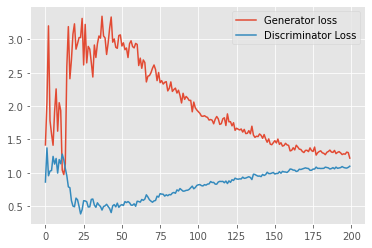

In [21]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('./output/loss.png')